# Wstęp do Sztucznej Inteligencji - rok akademicki 2023/2024

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `NrAlbumu_Nazwisko_Imie_PoprzedniaNazwa`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia.

# Temat: Optymalizacja globalna: Prosty algorytm genetyczny cz. I
Głownym celem zajęć poświęconych alorytmom genetycznym jest stworzenie od podstaw (implentacja) prostego algorytmu genetycznego i późniejsze wykorzystanie go do rozwiązania przykładowych zadań optymalizacji globalnej.

W tym notatniku będą Państwo mieli za zadanie zaimplementować funkcje wchodzące w skład procedury algorytmu genetycznego. 

## Import biblioteki numpy
Wszystkie funkcje należy tworzyć z wykorzystaniem biblioteki `numpy`.

In [1]:
import numpy as np

## Przykładowa funkcja celu
Zadanie optymalizacji w wielu przypadakach sprowadza się optymalizacji odpowiednio sformułowanej funkcj, tzw. funkcji celu. Poniżej przykładowa prosta funkcja umożliwiająca testowanie zaimplemetowanych funkcji.  

In [10]:
# testowa funkcja celu
# x - jednowymiarowa tablica ndarray
def obj_func(x):
    return (x**2).sum()

Przykład wywołania.

Wektor `x` to tak zwany osobnik, czyli jedno z możliwych (dopuszczalnych) rozwiązań.  

In [11]:
# przykład wywołania
x = np.array([1.2, 0.1, 3, 2.1])
print(obj_func(x))

14.86


Zadanie optymalizacji można sformułować jako zadanie poszukiwania minimum (minimalizacja) bądź maksimum (maksymalizacja) funkcji. 

Zaznaczmy, że rozwiązaniem problemu optymalizacji jest podanie nie tylko jaka jest wartość optymalna, ale również (a może nawet przede wszystkim) dla jakich wartości $x$ funkcja osiąga to optimum.

Przykład: Znajdź minimum funkcji $f(x)=x^2$ w przedziale $[-1, 1]$.

Rozwiązanie można sformułować następnująco: w przedziale $[-1, 1]$ funkcja $f(x)=x^2$ osiąga minimum równe $0$ dla $x=0$.

Zwróć uwagę, że powyższe zadanie można zdefiniować jako zadanie maksymalizacji:

Przykład: Znajdź maksimum funkcji $f(x)=-x^2$ w przedziale $[-1, 1]$.

Rozwiązanie jest takie samo, tzn. dla $x=0$ podana funkcja osiąga wartość $0$ (tym razem jest to maksimum). 

Zatem, implementując nasz aglorytm genetyczny do szukania maksimum funkcji, będziemy go w stanie użyć do szukania minimum danej funkcji, jeśli weźmiemy oryginalną funkcję i pomnożymy ją przez $-1$.


## Liczba potrzebnych bitów
W prostym algorytmie genetycznym wykorzystywane jest kodowanie binarne osobnika, tzn. każda z wartości rzeczywistych wektora `x` reprezentowana jest przez ciąg bitów (zer i jedynek).

Pierwszym krokiem zatem jest określenie ile potrzeba bitów aby móc zakodować wszystkie dopuszczalne rozwiązania z zadaną dokładnością.

### Zadanie 1
Zaimplementować metodę obliczającą ilość bitów potrzebnych do zakodowania liczby rzeczywistej z przedziału `[a, b]` z zadanym krokiem `dx`. Metoda ta powinna zwracać również nowy dokładniejszy krok `dx`.

Należy zatem na podstwie kroku `dx` oraz końców przedziału `a` i `b` określić ile liczb całkowitych będzie trzeba zakodować w postaci binarnej. Nasępnie dobrać najmniejszą liczbę bitów pozwalającą na zakodowanie tylu liczb.

__Przykład:__ `a=0`, `b=1`, `dx=0.1`

W przedziale `[0, 1]` z krokiem `0.1` mieści się 11 liczb (włącznie z końcami przedziału), zatem potrzebna liczba bitów to 4 bo na 4 bitach zakodujemy 16 (od 0 do 15) liczb a na 3 już tylko 8 (za mało). 

Ponieważ na 4 bitach zakodujemy 16 liczb to przy niezmienionym kroku liczba:
- `0000` odpowiada liczbie całkowitej 0 ($i$), a rzeczywistej 0.0 (wzór: $i*dx+a$)
- `1111` odpowiada liczbie całkowitej 15 ($i$), a rzeczywistej 1.5 (wzór: $i*dx+a$)

Jak widać liczba `1111` po rozkodowaniu wykracza poza dopuszczalny podział. Należy zatem zaktualizować krok `dx` tak aby `1111` odpowiadało dokładnie wartości `b`.

Argumenty funkcji:
- `a` - początek przedziału, liczba rzeczywista.
- `b` - koniec przedziału, liczba rzeczywista.
- `dx` - krok, dokładność kodowania, liczba rzeczywista.
- `B` - liczba bitów, liczba całkowita.
- `dx_new` - nowy dokładniejszy krok, liczba rzeczywista.

In [2]:
def nbits(a, b, dx):
    ### TWÓJ KOD TUTAJ

    B = int((np.abs(b-a)/dx)+1).bit_length()
    dx_new = np.abs(a-b)/(2**B - 1)

    return B, dx_new

In [3]:
# jeśli poniższe nie rzuca wyjątku to znaczy, że testy przeszły ale nie musi oznaczać, że wszystko jest dobrze
np.testing.assert_almost_equal(nbits(0, 1, 0.1)[0], 4, decimal=6)
np.testing.assert_almost_equal(nbits(0, 1, 0.1)[1], 0.06666666666666667, decimal=6)
np.testing.assert_almost_equal(nbits(-2.4, 3.1, 0.01)[0], 10, decimal=6)
np.testing.assert_almost_equal(nbits(-2.4, 3.1, 0.01)[1], 0.005376344086021506, decimal=6)

## Populacja początkowa
Algorytm genetyczny jest algorytmem działającym na pewnej populacji osobników (początkowo losowej), którą to poddaje się tzw. operacjom genetycznym.


### Zadanie 2
Zaimplementować metodę generującą początkową populację zakodowanych osobników (binarną). Metoda ta powinna zwracać obiekt typu `ndarray`. Użyj metody `np.random.randint`.

Jest to po prostu dwuwymiarowa tablica, gdzie pierwszy wymiar to liczba osobników, a drugi liczba zmiennych w osobniku razy liczba bitów na każdą z nich.

Uwaga: W naszej implementacji algortmu genetycznego, dla uproszczenia przyjmiemy, że każdą zmienną rzeczywistą kodować będziemy za pomocą takiej samej liczby bitów. Ułatwia to implementację, jednak warto pamiętać, że w rzeczywistych problemach może to nie wystarczyć. Może istnieć potrzeba dokładniejszego reprezentowania pewnej zmiennej rzeczywistej (wykorzystując większą liczbę bitów) niż innej. Problem ten pojawia się również, jeśli wszystkie zmienne chcemy reprezentować z tą samą dokładności, ale zakresy ich wartości różnią się - aby osiągnąć tę samą dokładność przy większym zakresie wartości musimy użyć większej liczby bitów. 

Warto zwrócić uwagę, że szukając rozwiązania jako liczby rzeczywistej ale stosująć kodowanie binarne, z góry wiemy, że pewnych wartości nie będziemy w stanie reprezentować wykorzystując przyjętą liczbę bitów. 

Przykładowo, mamy za zadanie znalezienie minimum funkcji

$f(x) = x^2$

w przedziale $[-1, 1]$.

Wiadomo, że minimum tej funkcji jest w $x=0$ i wynosi $f(0)=0^2=0$. Jeśli jednak nasze rozwiązania reprezentujemy za pomocą 2 bitów, nie jesteśmy w stanie reprezentować wartości zero. Uruchom poniższy przykład.



In [6]:
import numpy as np

def fun(x):
    return x*x

a = -1.0
b = 1.0

bits_num = 2

print('{0:>6} | {1:>15} | {2:>15}'.format('binary', 'decoded', 'wartosc funkcji'))
for i in range(2**bits_num):
    binary_solution = bin(i)[2:].zfill(bits_num)
    decoded_solution = a + i*(b-a)/(2**bits_num-1)
    print('{0:>6} | {1:15.10f} | {2:15.10f}'.format(binary_solution, decoded_solution, fun(decoded_solution)))

binary |         decoded | wartosc funkcji
    00 |   -1.0000000000 |    1.0000000000
    01 |   -0.3333333333 |    0.1111111111
    10 |    0.3333333333 |    0.1111111111
    11 |    1.0000000000 |    1.0000000000


Jeśli użyjemy trzech bitów, również nie jesteśmy w stanie reprezentować zera, jednak najlepsze (najbliższe 0) rozwiązanie, jakie jesteśmy w stanie reprezentować jest bliżej rzeczywistego.

In [7]:
import numpy as np

def fun(x):
    return x*x

a = -1.0
b = 1.0

bits_num = 3

print('{0:>3} | {1:>15} | {2:>15}'.format('binary', 'decoded', 'wartosc funkcji'))
for i in range(2**bits_num):
    binary_solution = bin(i)[2:].zfill(bits_num)
    decoded_solution = a + i*(b-a)/(2**bits_num-1)
    print('{0:>6} | {1:15.10f} | {2:15.10f}'.format(binary_solution, decoded_solution, fun(decoded_solution)))

binary |         decoded | wartosc funkcji
   000 |   -1.0000000000 |    1.0000000000
   001 |   -0.7142857143 |    0.5102040816
   010 |   -0.4285714286 |    0.1836734694
   011 |   -0.1428571429 |    0.0204081633
   100 |    0.1428571429 |    0.0204081633
   101 |    0.4285714286 |    0.1836734694
   110 |    0.7142857143 |    0.5102040816
   111 |    1.0000000000 |    1.0000000000


Warto zaznaczyć jeszcze jedną rzecz. Typy float i double również są reprezentowane w komputerach binarnie i mają swoje ograniczenia - niektórych wartości nie da się reprezentować. Zatem zwiększanie liczby bitów w naszej implementacji również ma sens tylko do pewnego momentu.

Zaimplementuj funkcję generującą początkową populację zakodowanych osobników (binarną). Metoda ta powinna zwracać obiekt typu ndarray. Użyj metody np.random.randint.

Argumenty funkcji:
- `P` - liczba osobników, liczba całkowita.
- `N` - liczba zmiennych, liczba całkowita.
- `B` - liczba bitów na każdą ze zmiennych, liczba całkowita.
- `pop` - populacja zakodowanych osobników, tablica `ndarray`.

In [4]:
def gen_population(P, N, B):
    ### TWÓJ KOD TUTAJ

    pop = np.random.randint(2, size = (P, N*B))

    return pop

In [5]:
# jeśli poniższe nie rzuca wyjątku to znaczy, że testy przeszły ale nie musi oznaczać, że wszystko jest dobrze
np.testing.assert_array_almost_equal(np.array(gen_population(5, 2, 3).shape), np.array((5, 6)))
np.testing.assert_array_almost_equal(np.array(gen_population(10, 3, 8).shape), np.array((10, 24)))

## Dekodowanie osobnika
Aby móc ocenić danego osbnika (podstawić go do funkcji celu) należy go zdekodować, czyli każdą ze zmiennych w postaci binarnej zamienić na liczbę rzeczywistą. Patrz przykład do zadania pierwszego.

### Zadanie 3
Zaimplementuj metodę pozwalajacą na rozkodowanie osobników, tzn. przekonwertowanie osobnika z postaci binarnej na rzeczywistą. Metoda powinna zwrócić jedno wymiarową tablicę `ndarray`.

Argumenty funkcji:
- `individual` - osobnik binarny kodujący `N` zmiennych rzeczywistych, tablica `ndarray`.
- `N` - liczba zmiennych, liczba całkowita.
- `B` - liczba bitów na każdą ze zmiennych, liczba całkowita.
- `a` - początek przedziału, liczba rzeczywsta, dla każdej zmiennej taki sam.
- `dx` - krok, dokładność kodowania, taki sam dla każdej zmiennej.
- `decode_individual` - rozkodowany osobnik, tablica `ndarray` zawierająca `N` zmiennych rzeczywistych.

__Ważne__: Funkcja ta wykonywana będzie w każdej iteracji algorytmu (wielokrotnie) należy zatem zadbać o to aby było ona zaimplementowana w sposób wydajny.

In [6]:
def decode_individual(individual, N, B, a, dx):
    ### TWÓJ KOD TUTAJ

    decode = np.zeros(N)
    individual = individual.reshape(N, B)
    for x in enumerate(individual):
      tmp = ''
      for y in x[1]:
        tmp += str(y)
      decode[x[0]] = int(tmp, 2)

    return decode * dx + a

In [7]:
# jeśli poniższe nie rzuca wyjątku to znaczy, że testy przeszły ale nie musi oznaczać, że wszystko jest dobrze
a = -1
N = 2
B = 5
dx = 0.06451612903225806
pop = np.array([[0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]])
dpop = np.array([[-0.5483871, 0.03225806], [-0.48387097, -0.41935484], [-0.48387097, 0.80645161], [0.22580645, 0.80645161], [1.0, 0.87096774]])
for i, ind in enumerate(pop):
    np.testing.assert_array_almost_equal(decode_individual(ind, N, B, a, dx), dpop[i])

## Ocena całej populacji
Gdy już umiemy rozkodować osobiki to możemy na każdym z nich obliczyć wartość funkcji celu.

### Zadanie 4
Zaimplementuj metodę oceny osobników w populacji, tzn. metodę wykonującą funkcję celu na każdym z osobników. Metoda powinna zwrócić jedno wymiarową tablicę `ndarray`.

Wejściem do funkcji jest populacja zakodowana, tak więc należy wykorzystać funkcję z zadania 3 do rozkodowania osobnika a następnie wywołać na nim funkcje celu.

Argumety funkcji:
- `func` - funkcja celu (przystosowania).
- `pop` - populacja zakodowanych osobników, tablica `ndarray`.
- `N` - liczba zmiennych, liczba całkowita.
- `B` - liczba bitów na każdą ze zmiennych, liczba całkowita.
- `a` - początek przedziału, liczba rzeczywsta, dla każdej zmiennej taki sam.
- `dx` - krok, dokładność kodowania, taki sam dla każdej zmiennej.
- `evaluated_pop` - tablica `ndarray` zawierająca wartości funkcji celu dla poszczególnych osobników.

__Ważne__: Funkcja ta wykonywana będzie w każdej iteracji algorytmu (wielokrotnie) należy zatem zadbać o to aby było ona zaimplementowana w sposób wydajny.

In [8]:
def evaluate_population(func, pop, N, B, a, dx):
    ### TWÓJ KOD TUTAJ

    evaluated_pop = np.zeros(len(pop))
    for x in enumerate(pop):
      value = decode_individual(x[1], N, B, a, dx)
      evaluated_pop[x[0]] = func(value)

    return evaluated_pop

In [12]:
# jeśli poniższe nie rzuca wyjątku to znaczy, że testy przeszły ale nie musi oznaczać, że wszystko jest dobrze
a = -1
N = 2
B = 5
dx = 0.06451612903225806
pop = np.array([[0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]])
epop = np.array([0.30176899, 0.40998959, 0.88449532, 0.70135276, 1.75858481])
np.testing.assert_array_almost_equal(evaluate_population(obj_func, pop, N, B, a, dx), epop)

## Wybór najlepszego osobnika
W działaniu algorytmu genetycznego chodzi o to aby znaleźć osobnika, który ma nalepszą wartość funkcji. Będziemy implementować algorytm genetyczny w wersji algortmu maksymalizującego wartość funkcji celu. Zatem najlepszy osobnik to ten,którego wartość funkcji celu jest największa.

### Zadanie 5
Zaimplementować metodę zwracającą najlepszego osobnika z populacji (maksimum). Metoda powinna zwracać osobnika w postaci jednowymiarowej tablicy `ndarray` oraz odpowiadającą mu wartość funkcji celu.

- `pop` - populacja zakodowanych osobników, tablica `ndarray`.
- `evaluated_pop` - tablica `ndarray` ocen osobników.
- `best_individual` - najlepszy osobnik (zakodowany), tablica `ndarray`.
- `best_value` - wartość najlepszego osobnika, liczba rzeczywista.

__Ważne__: Funkcja ta wykonywana będzie w każdej iteracji algorytmu (wielokrotnie) należy zatem zadbać o to aby było ona zaimplementowana w sposób wydajny.

In [13]:
def get_best(pop, evaluated_pop):
    ### TWÓJ KOD TUTAJ

    best_individual = pop[np.argmax(evaluated_pop)]
    best_value = evaluated_pop[np.argmax(evaluated_pop)]

    return best_individual, best_value

In [14]:
# jeśli poniższe nie rzuca wyjątku to znaczy, że testy przeszły ale nie musi oznaczać, że wszystko jest dobrze
pop = np.array([[0, 0, 1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 1, 1, 0, 0], [1, 0, 0, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]])
epop = np.array([0.30176899, 0.40998959, 0.88449532, 0.70135276, 1.75858481])
np.testing.assert_array_almost_equal(get_best(pop, epop)[0], np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]))
np.testing.assert_almost_equal(get_best(pop, epop)[1], 1.75858481)

## Selekcja: Metoda koła ruletki
Metoda ruletki (koła ruletki)– jedna z najbardziej podstawowych metod selekcji. Polega na utworzeniu koła ruletki z polami odpowiadającymi poszczególnym osobnikom. Wielkość pól jest proporcjonalna do wartości funkcji przystosowania (celu). Proces selekcji oparty jest na obrocie ruletką tyle razy ile osobników jest w populacji i na wyborze za każdym razem jednego osobnika do nowej populacji. Pewne osobniki są wybierane więcej niż jeden raz, niektóre dokładnie raz, a niektóre wcale.

Koło ruletki w praktyce:
- Koło zestępujemy odcinkiem $[0,1]$, który dzielimy na tyle podprzedziałów ile osobników w populacji.
- Rozmiar każdego podprzedziału jest proporcjonalny do wartość funkcji celu danego osobnika, tzn. im większa wartość funkcji celu tym odcinek powinnien być większy. Ponieważ cały odcinek ma długośc 1 to rozmiary podprzedziałów można utożsamoć z prawdopodobieństwe przejścia osobnika do nowej populacji i policzyć ze wzoru $p_i= \frac{e_i}{\sum_i{e_i}}$, gdzie $i$ to numer osobnika, a $e_i$ to wartość funkcji celu $i$-tego osobnika.
- Zamiast kręcić kołem, losujemy liczbę z przedziału $[0,1]$ i sprawdzamy w którym podprzedziale się ona zawiera i osobnika o numerze zgodnym z numerem tego podprzedziału wybieramy do nowej populacji.  

Warto zwrócić na fakt, że tak zaproponowany wzór na długości przedziałów $p_i$ zadziała tylko wtedy gdy wszystkie wartości funkcji celu będą dodatnie. Aby to zapewnić wystarczy na początku do wektora wartości funkcji celu dodać odpowiednią stałą zapewniającą dodatniość (lub przynajmniej nieujemność) wszystkich elementów.



### Zadanie 6
Zaimplementuj operator selekcji. Selekcja metodą koła ruletki.

Argumenty funkcji:
- `pop` - populacja zakodowanych osobników, tablica `ndarray`.
- `evaluated_pop` - tablica `ndarray` ocen osobników.
- `new_pop` - nowa populacja wybranych osobników (zakodowanych), tablica `ndarray`.

In [3]:
def roulette(pop, evaluated_pop):
    ### TWÓJ KOD TUTAJ

    roulette = np.zeros(len(pop))
    new_pop = np.zeros((len(pop), len(pop[0])))
    for i in range(len(pop)):
        roulette[i] = evaluated_pop[i] / evaluated_pop.sum()
    for i in range(len(pop)):
        rand = np.random.rand()
        for j in range(len(pop)):
            rand -= roulette[j]
            if rand <= 0:
                new_pop[i] = pop[j]                
                break

    return new_pop

## Krzyżowanie
Operacja krzyżowania polega na wymianie fragmentów łańcuchów dwóch osobników rodzicielskich. Krzyżowanie jest kluczowym operatorem w algorytmach genetycznych, stanowiącym o ich sile i efektywności.

Ideą operatorów krzyżowania jest wymiana kodu genetycznego pomiędzy osobnikami, tak jak to się dzieje w naturze. Stworzono wiele teorii i rodzajów krzyżowań, które stosowane są do różnych rodzajów zadań i są zależne od sposobu kodowania. Dla potrzeb klasycznego algorytmu genetycznego opisano operator krzyżowania jednopunktowego. 

Krzyżowanie jednopunktowe – krzyżowanie zachodzi z pewnym prawdopodobieństwem `pk`; dla każdego osobnika losuje się liczbę i sprawdza, czy zachodzi krzyżowanie. Następnie dobiera się wybrane osobniki losowo w pary. Losuje się liczbę określającą miejsce krzyżowania i wymienia kod.

Podpowiedź: w praktyce krzyżowanie to można zaimplementować na dwa sposoby.

Sposób 1. Mając tablicę `pop` z parzystą liczbą osobników jako wiersze, dla każdych kolejnych dwóch wierszy wylosuj liczbę losową z przedziału `[0,1]`. Jeśli jest ona mniejsza niż prawdopodobieństwo krzyżowania, skrzyżuj osobniki i oboje potomków umieść w populacji wynikowej. Jeśli wartość losowa jest większa niż prawdopodobieństwo krzyżowania, skopiuj oboje rodziców do populacji wynikowej. 

Sposób 2. Mając tablicę `pop` z dowolną (niekoniecznie parzystą) liczbą osobników jako wiersze, dla każdego wiersza wylosuj liczbę losową z przedziału `[0,1]`. Jeśli jest ona mniejsza niż prawdopodobieństwo krzyżowania, skrzyżuj osobnika z osobnikiem w następnym wierszu i dowolnego z potomków (jednego!) umieść w populacji wynikowej. Jeśli wartość losowa jest większa niż prawdopodobieństwo krzyżowania, skopiuj aktualny wiersz do populacji wynikowej. Uwaga: ostatni wiersz krzyżowany jest z pierwszym (następnym w sensie "modulo").

![krzyzowanie.PNG](http://torus.uck.pk.edu.pl/~amarsz/images/krzyzowanie.PNG)




### Zadanie 7
Zaimplementuj operator krzyżowania. Krzyżowanie jedno-punktowe.

Argumenty funkcji:
- `pop` - populacja zakodowanych osobników, tablica `ndarray`.
- `pk` - prawdopodobieństwo krzyżowania dla pary osobników. Liczba rzeczywista z przedziału $[0,1]$.
- `new_pop` - nowa populacja osobników po krzyżowaniu (zakodowanych), tablica `ndarray`.

In [4]:
def cross(pop, pk):
    ### TWÓJ KOD TUTAJ

    new_pop = np.zeros((len(pop), len(pop[0])))
    len_pop = len(pop)
    len_chrom = len(pop[0])
    for i in range(0, len_pop):
        rand = np.random.rand()
        if rand <= pk:
            new_pop[i] = np.concatenate((pop[i][0:len_chrom//2], pop[(i+1)%len_pop][len_chrom//2:len_chrom]))
        else:
            new_pop[i] = pop[i]

    return new_pop

## Mutacja
Mutacja polega na wprowadzeniu do istniejących, zakodowanych osobników, pewnych losowych zmian. Mutacja tworzy nowego osobnika na bazie jednego i tylko jednego rodzica. Jest wiele metod tworzenia nowych osobników za pomocą operatora mutacji.

Podstawową formę mutacji można zapisać następująco:
$$x'= m(x)$$
gdzie: $x$ jest osobnikiem rodzica, $m$ funkcją mutacji, $x'$ to potomek, osobnik zmutowany.

Mutacja również zachodzi z pewnym zadanym prawdopodobieństwem `pm`. Można ją zaimplementować na dwa sposoby.

Sposób 1. Dla każdego osobnika losuje się liczbę sprawdzając czy będzie on podlegał mutacji. Jeśli tak to losuje się gen, który będzie zmutowany i dokonuje się mutacji (tu: negacja bitu). 

Sposób 2. Dla danego osobnika, dla każdego genu (bitu) osobno losuje się liczbę sprawdzającą czy będzie podlegał mutacji. Jeśli tak, dokonuje się jego mutacji (u nas: negacja bitu).

Mutacja w klasycznym algorytmie genetycznym odgrywa drugorzędną rolę. Częstość mutacji potrzebna do uzyskania dobrych wyników w empirycznych badaniach nad algorytmami genetycznymi jest rzędu jeden do tysiąca skopiowanych bitów. W naturalnych populacjach częstość jest równie mała lub nawet mniejsza. 

W przypadku osobników zakodowanych binarnie (klasyczny algorytm genetyczny) nie ma problemu ze stosowaniem mutacji (po prostu zamieniamy wartość genu na przeciwny). 

### Zadanie 8
Zaimplementuj operator mutacji. Mutacja bitowa.

Argumenty funkcji:
- `pop` - populacja zakodowanych osobników, tablica `ndarray`.
- `pm` prawdopodobieństwo mutacji dla pojedynczego bitu. Liczba rzeczywista z przedziału $[0,1]$.
- `new_pop` - nowa populacja osobników po mutacji (zakodowanych), tablica `ndarray`.

In [5]:
def mutate(pop, pm):
    ### TWÓJ KOD TUTAJ

    mutated_pop = np.random.choice([0, 1], size=(len(pop),len(pop[0])), p=[1-pm, pm])
    new_pop = pop ^ mutated_pop

    return new_pop

## Zadanie 1  (obowiązkowe, 1pkt.)
W komórce poniżej wprowdź swój nr albumu a następnie ją wykonaj:

In [1]:
nr_albumu = 142706
nr_funkcji = (nr_albumu % 16) + 1
print('Twój nr funkcji celu to:', nr_funkcji if nr_funkcji != 6 else 7)

Twój nr funkcji celu to: 3


Zgodnie z wygenerowanym numerem, wybierz funkcję celu ze strony: https://www.sfu.ca/~ssurjano/optimization.html z działu "Many Local Minima".

Zaplementuj ją jako funkcję w Pythonie.

Dla wszystkich funkcji przyjmujemy `N=2` tzn. rozważamy ją jako funkcję dwóch zmiennych $f(x_1, x_2)$.

TWÓJ PROGRAM:

In [2]:
def obj_func(x):
    ### TWÓJ KOD TUTAJ

    return -0.0001*((abs(np.sin(x[0])*np.sin(x[1])*np.exp(abs(100 - (np.sqrt(x[0]**2 + x[1]**2)/np.pi)))) + 1)**(0.1))

## Zadanie 2  (obowiązkowe, 1pkt.)
Przygotuj wykres 3D funkcji zaimplementowanej w zadaniu nr 1.

TWÓJ PROGRAM:

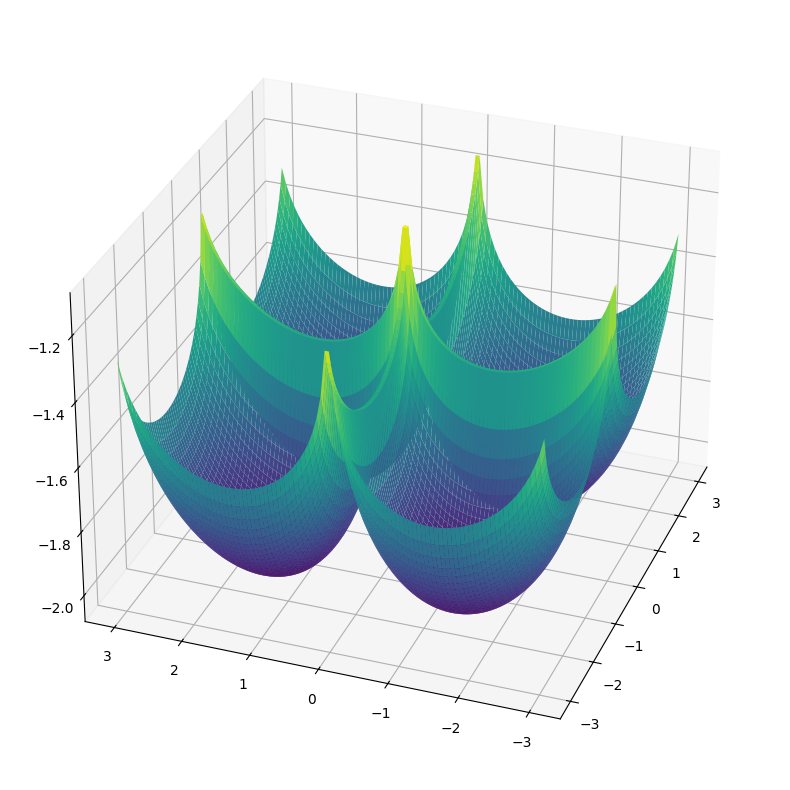

In [3]:
### TWÓJ KOD TUTAJ

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

n = 100
sampled = np.linspace(-3, 3, n)
x, y = np.meshgrid(sampled, sampled)
z = obj_func([x,y])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)
ax.view_init(30, 200)
plt.show()

## Zadanie 3 (obowiązkowe, 2pkt.)
Korzystając z zaimplementowanych funkcji, zaimplementuj główną pętlę klasycznego algorytmu genetyczengo.
![pag_schemat.png](http://torus.uck.pk.edu.pl/~amarsz/images/pag_schemat.png)

Implementacja powinna mieć postać funkcji, która przyjmuje parametry:

- `fun` - funkcja, której maksimum ma zostać znalezione
- `pop_size` - rozmiar populacji
- `pk` - prawdopodobieństwo krzyżowania
- `pm` - prawdopodobieństwo mutacji
- `generations` - liczba pokoleń 
- `dx` - dokładność kodowania

Funkcja powinna zwracać:
- `best_sol` - najlepsze znalezione rozwiązanie (nieważne, w której iteracji; UWAGA! niekoniecznie jest to najlepszy osobnik z ostatniej populacji)
- `best_generation` - numer pokolenia, z którego pochodzi najlepsze rozwiązanie
- `list_best` - lista z najlepszą oceną osobnika w każdym pokoleniu (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
- `list_best_generation` - lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
- `list_mean` - lista z wartościami średnimi ocen osobników z każdego pokolenia

TWÓJ PROGRAM:

In [4]:
# Miejsce na twój kod

def evolve(fun, pop_size, px, pm, generations, d):
    #generuj początkową populację
    #oceń osobniki w populacji
    #znajdź i zapamiętaj najlepsze rozwiązanie
    #uaktualnij listy statystyk

    population = np.random.uniform(0, 10, size=(pop_size, len(dx)))
    listBest = []
    listBestGeneration = []
    listMean = []
    bestSolution = None
    bestGenerationNumber = None
    
    for i in range(generations):
        #selekcja
        #krzyżowanie
        #mutacja
        #oceń osobniki w populacji
        #znajdź i zapamiętaj najlepsze rozwiązanie, jeśli jest lepsze niż dotychczasowe najlepsze
        #uaktualnij listy statystyk

        fitness = np.array([fun(individual) for individual in population])
        maxFitnessIndex = np.argmax(fitness)
        if bestSolution is None or fitness[maxFitnessIndex] > fun(bestSolution):
            bestSolution = population[maxFitnessIndex]
            bestGenerationNumber = i

        listBest.append(fun(bestSolution))
        listBestGeneration.append(np.max(fitness))
        listMean.append(np.mean(fitness))

        rankedIndices = np.argsort(fitness)
        rankedFitness = np.arange(pop_size)
        normalizedFitness = rankedFitness / np.sum(rankedFitness)
        selectedIndices = np.random.choice(rankedIndices, size=pop_size, replace=True, p=normalizedFitness)

        for i in range(0, pop_size, 2):
            if np.random.rand() < px:
                crossoverPoint = np.random.randint(len(dx))
                population[selectedIndices[i], crossoverPoint:], population[selectedIndices[i + 1], crossoverPoint:] = \
                    population[selectedIndices[i + 1], crossoverPoint:], population[selectedIndices[i], crossoverPoint:]

        for i in range(pop_size):
            for j in range(len(dx)):
                if np.random.rand() < pm:
                    population[i, j] += np.random.uniform(-0.5*dx[j], 0.5*dx[j])

    return bestSolution, bestGenerationNumber, listBest, listBestGeneration, listMean

## Zadanie 4 (obowiązkowe, 1pkt.)

Zaprezentuj działanie algorytmu z przykładowymi wartościami parametrów:

- `pop_size`: 60
- `pk`: 0.7
- `pm`: 0.01
- `generations`: 200
- `dx`: 1e-10

Na wykresach funkcji 3D przedstaw położenie osobników z pierwszej populacji, w połowie ewolucji oraz końcowej populacji. Zaznacz wyraźnie położenie najlepszeg rozwiązania.

Na wykresach 2D przedstaw przebieg wartości z list z zebranymi statystykami (listy `list_best`, `list_best_generation`, `list_mean`) w zależności od numeru pokolenia. 

TWÓJ PROGRAM:

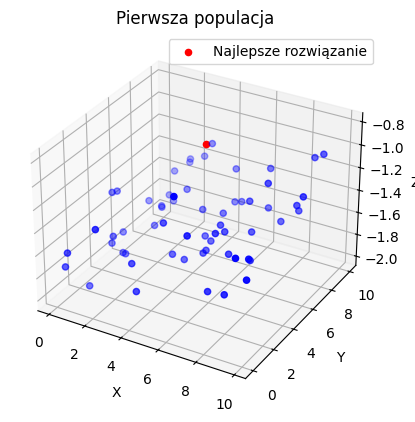

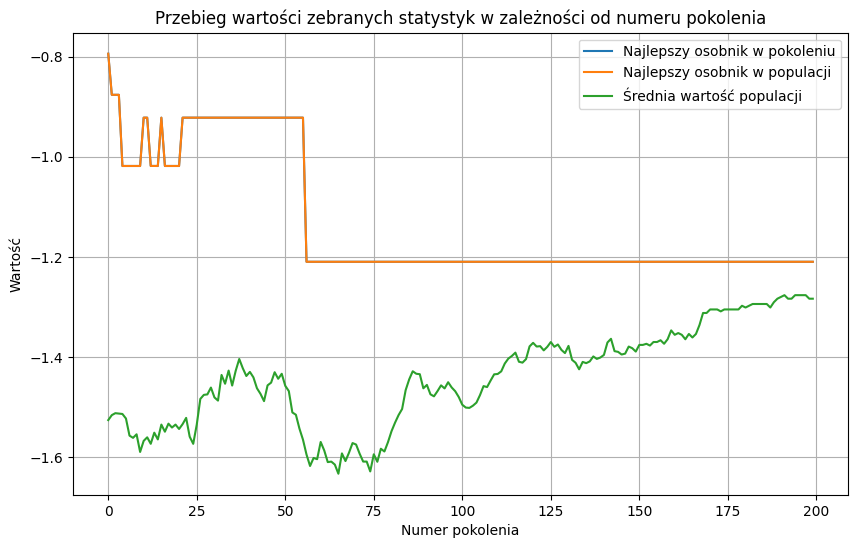

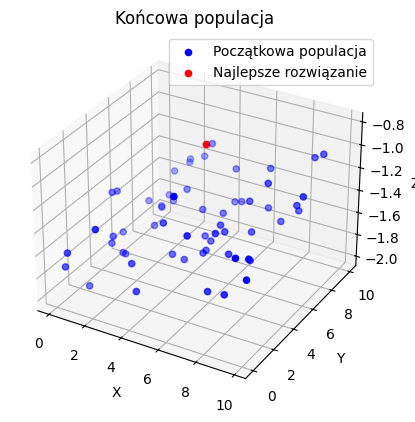

In [5]:
### TWÓJ KOD TUTAJ

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_population(ax, population, color='b', label=None):
    z = np.array([obj_func(ind) for ind in population])
    ax.scatter(population[:, 0], population[:, 1], z, c=color, label=label)

pop_size = 60
pk = 0.7
pm = 0.01
generations = 200
dx = [1e-10, 1e-10]

population = np.random.uniform(0, 10, size=(pop_size, len(dx)))
best_sol, best_generation, list_best, list_best_generation, list_mean = evolve(obj_func, pop_size, pk, pm, generations, dx)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_population(ax, population)
ax.scatter(best_sol[0], best_sol[1], obj_func(best_sol), color='r', label='Najlepsze rozwiązanie')
ax.set_title('Pierwsza populacja')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(generations), list_best, label='Najlepszy osobnik w pokoleniu')
plt.plot(range(generations), list_best_generation, label='Najlepszy osobnik w populacji')
plt.plot(range(generations), list_mean, label='Średnia wartość populacji')
plt.xlabel('Numer pokolenia')
plt.ylabel('Wartość')
plt.title('Przebieg wartości zebranych statystyk w zależności od numeru pokolenia')
plt.legend()
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_population(ax, population, label='Początkowa populacja')
plot_population(ax, best_sol.reshape(1, -1), color='r', label='Najlepsze rozwiązanie')
ax.set_title('Końcowa populacja')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

## Zadanie 5 (obowiązkowe, 5pkt.)

Zbadaj wpływ parametrów klasycznego algorytmu genetycznego na jego zdolność znalezienia optymalnego rozwiązania. Dla ułatwienia analizy, zmieniając jeden parametr, zachowaj typowe wartości pozostałych.

1. Jak działa algorytm z typowymi ustawieniami parametrów (jak w zadaniu 4)? Podaj średnią wartość przystosowania znalezionego rozwiązania po wielokrotnym uruchomieniu AG.
2. Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"? Porównaj zarówno jak dobre rozwiązanie zostało znalezione jak również w której generacji.
    - `generations`: kilka różnych wartości z przedziału [100, 10000]
3. Czy mutacja jest potrzebna? 
    - `pm` = 0.0
4. Jak działa algorytm bez krzyżowania, z samą mutacją? 
    - `pk` = 0.0
5. Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą, jeśli liczba ewaluacji funkcji jest taka sama (np. 2000)?
    - porównaj dwa ustawienia: `pop_size`=20, `generations`=100  vs. `pop_size`=100, `generations`=20.

UWAGA: Powyższe porównania powinny być wykonane na podstawie uśrednionych wyników co najmniej 10 uruchomień algorytmu z danymi parametrami. Podając wyniki podaj średnią z najlepszych znalezionych rozwiązań oraz odchylenie standardowe oraz numer pokolenia, w którym znaleziono rozwiązanie.

TWÓJ PROGRAM:

In [6]:

wynik_1, wynik_2, wynik_3, wynik_4, wynik_51, wynik_52 = [], [], [], [], [], []
srednia_1, srednia_2, srednia_3, srednia_4, srednia_51, srednia_52 = 0, 0, 0, 0, 0, 0
odchylenie_1, odchylenie_2, odchylenie_3, odchylenie_4, odchylenie_51, odchylenie_52 = 0, 0, 0, 0, 0, 0
pokolenie_1, pokolenie_2, pokolenie_3, pokolenie_4, pokolenie_51, pokolenie_52 = 0, 0, 0, 0, 0, 0
exec_num = 10  # lub więcej

for i in range(exec_num):
    wynik_1.append(evolve(obj_func, 60, 0.7, 0.01, 200, [1e-10, 1e-10]))
    wynik_2.append(evolve(obj_func, 60, 0.7, 0.01, 200*(i+1) if i < 5 else 2000*(i-4), [1e-10, 1e-10]))
    wynik_3.append(evolve(obj_func, 60, 0.7, 0.00, 200, [1e-10, 1e-10]))
    wynik_4.append(evolve(obj_func, 60, 0.0, 0.3, 200, [1e-10, 1e-10]))
    wynik_51.append(evolve(obj_func, 20, 0.7, 0.01, 100, [1e-10, 1e-10]))
    wynik_52.append(evolve(obj_func, 100, 0.7, 0.01, 20, [1e-10, 1e-10]))

for x in wynik_1:
    srednia_1 += x[0]
    pokolenie_1 += x[1]
srednia_1 /= exec_num
pokolenie_1 /= exec_num
for x in wynik_1:
    odchylenie_1 += (x[0] - srednia_1) ** 2
odchylenie_1 = np.sqrt(odchylenie_1 / exec_num)
print(f'Zadanie 1: \nŚrednia: {srednia_1}\nOdchylenie: {odchylenie_1}\nPokolenie: {pokolenie_1}\n\n')

for x in wynik_2:
    srednia_2 += x[0]
    pokolenie_2 += x[1]
srednia_2 /= exec_num
pokolenie_2 /= exec_num
for x in wynik_2:
    odchylenie_2 += (x[0] - srednia_2) ** 2
odchylenie_2 = np.sqrt(odchylenie_2 / exec_num)
print(f'Zadanie 2: \nŚrednia: {srednia_2}\nOdchylenie: {odchylenie_2}\nPokolenie: {pokolenie_2}\n\n')

for x in wynik_3:
    srednia_3 += x[0]
    pokolenie_3 += x[1]
srednia_3 /= exec_num
pokolenie_3 /= exec_num
for x in wynik_3:
    odchylenie_3 += (x[0] - srednia_3) ** 2
odchylenie_3 = np.sqrt(odchylenie_3 / exec_num)

print(f'Zadanie 3: \nŚrednia: {srednia_3}\nOdchylenie: {odchylenie_3}\nPokolenie: {pokolenie_3}\n\n')

for x in wynik_4:
    srednia_4 += x[0]
    pokolenie_4 += x[1]
srednia_4 /= exec_num
pokolenie_4 /= exec_num
for x in wynik_4:
    odchylenie_4 += (x[0] - srednia_4) ** 2
odchylenie_4 = np.sqrt(odchylenie_4 / exec_num)
print(f'Zadanie 4: \nŚrednia: {srednia_4}\nOdchylenie: {odchylenie_4}\nPokolenie: {pokolenie_4}\n\n')

for x in wynik_51:
    srednia_51 += x[0]
    pokolenie_51 += x[1]
srednia_51 /= exec_num
pokolenie_51 /= exec_num
for x in wynik_51:
    odchylenie_51 += (x[0] - srednia_51) ** 2
odchylenie_51 = np.sqrt(odchylenie_51 / exec_num)
print(f'Zadanie 5.1: \nŚrednia: {srednia_51}\nOdchylenie: {odchylenie_51}\nPokolenie: {pokolenie_51}\n\n')

for x in wynik_52:
    srednia_52 += x[0]
    pokolenie_52 += x[1]
srednia_52 /= exec_num
pokolenie_52 /= exec_num
for x in wynik_52:
    odchylenie_52 += (x[0] - srednia_52) ** 2
odchylenie_52 = np.sqrt(odchylenie_52 / exec_num)
print(f'Zadanie 5.2: \nŚrednia: {srednia_52}\nOdchylenie: {odchylenie_52}\nPokolenie: {pokolenie_52}\n\n')



Zadanie 1: 
Średnia: [5.87023733 4.18607373]
Odchylenie: [2.3577176  3.02393537]
Pokolenie: 198.4


Zadanie 2: 
Średnia: [6.63387917 8.09388783]
Odchylenie: [2.57258944 1.89077101]
Pokolenie: 3297.3


Zadanie 3: 
Średnia: [4.78290924 5.82898168]
Odchylenie: [2.62673223 2.76015224]
Pokolenie: 172.6


Zadanie 4: 
Średnia: [7.44928458 7.15819846]
Odchylenie: [2.86830455 2.88842758]
Pokolenie: 0.0


Zadanie 5.1: 
Średnia: [4.23670556 5.18543877]
Odchylenie: [3.06908852 2.17022058]
Pokolenie: 96.4


Zadanie 5.2: 
Średnia: [6.07105762 6.10977284]
Odchylenie: [3.39278292 3.28516903]
Pokolenie: 17.6




UMIEŚĆ TWOJE WNIOSKI I KOMENTARZE W KOMÓRCE PONIŻEJ

Odnieś się do każdego punktu.

&copy; Katedra Informatyki, Politechnika Krakowska